In [1]:
# For Data Processing
import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd
import openpyxl
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.display.max_rows = 150

/Users/jun/miniforge3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# ML Algorithms used 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

## mac

In [47]:
df = pd.read_excel('/Users/jun/Library/CloudStorage/OneDrive-개인/clinical db stomach/ML/early_complication_0529.xlsx', engine = "openpyxl")

In [48]:
df = df[['Sex','Age_group','OP_year',"stm.op.exceptca","stm.op.ca","oth.ca.within1Y","oth.ca","Adjuvant",
         "bf.op.CTx","Diagnosis", "Operation","Size","Lauren",'Smoking','Drinking','BMI', 
          'Ass_condition_HT','Ass_condition_DM','Ass_lesion',"Cytology",
         'Clinical_Stage','fStage_group','Location_nm','Histology','Reconstruction',
         'LN_Dissection_nm','Z_EBL','OP_time','Platelets','Albumin','Cell_Count',"WBC",
         "Lymphocytes","Combined_Resection_None","Combined_op_None","ASA_Score",
         "Intraop_cc_bleeding","Intraop_cc_organ_injury","Intraop_cc_cardia","Intraop_cc_anastomosis_failure",
         "Intraop_cc_others",
         'Early_CC_YN']]

In [49]:
#df = df.fillna({'hospital_stay_days':df['hospital_stay_days'].median()}) # median value로 ??
df = df.fillna({'BMI':df['BMI'].mean()})
df = df.fillna({'Size':df['Size'].median()})

df["Sex"]          = df["Sex"].replace('M',1)
df["Sex"]          = df["Sex"].replace('F',0)

df["Diagnosis"]          = df["Diagnosis"].replace('AGC',1)
df["Diagnosis"]          = df["Diagnosis"].replace('EGC',0)

df["Clinical_Stage"]   = df["Clinical_Stage"].replace(99, "I")
df["Clinical_Stage"]   = df["Clinical_Stage"].replace(np.nan, "I")

df["LN_Dissection_nm"] = df["LN_Dissection_nm"].replace(np.nan, "1. D1")

df["LN_Dissection_nm"] = df["LN_Dissection_nm"].replace('1. D1', 1)
df["LN_Dissection_nm"] = df["LN_Dissection_nm"].replace("2. D2", 0)

df["Lauren"]           = df["Lauren"].replace(np.nan, "Intestinal")

df["Smoking"]          = df["Smoking"].replace('Yes',1)
df["Smoking"]          = df["Smoking"].replace('No',0)
df["Smoking"]          = df["Smoking"].replace(np.nan, 0)


df["Drinking"]         = df["Drinking"].replace('Yes',1)
df["Drinking"]         = df["Drinking"].replace('No',0)
df["Drinking"]         = df["Drinking"].replace(np.nan, 1)

df["Cytology"]         = df["Cytology"].replace(1, "Negative")


df["Ass_lesion"]       = df["Ass_lesion"].replace('Yes',1)
df["Ass_lesion"]       = df["Ass_lesion"].replace('No',0)

df["stm.op.exceptca"]  = df["stm.op.exceptca"].replace('Yes',1)
df["stm.op.exceptca"]  = df["stm.op.exceptca"].replace('No',0)

df["stm.op.exceptca"]  = df["stm.op.exceptca"].replace('Yes',1)
df["stm.op.exceptca"]  = df["stm.op.exceptca"].replace('No',0)

df["stm.op.ca"]        = df["stm.op.ca"].replace('Yes',1)
df["stm.op.ca"]        = df["stm.op.ca"].replace('No',0)

df["oth.ca.within1Y"]  = df["oth.ca.within1Y"].replace('Yes',1)
df["oth.ca.within1Y"]  = df["oth.ca.within1Y"].replace('No',0)

df["oth.ca"]           = df["oth.ca"].replace('Yes',1)
df["oth.ca"]           = df["oth.ca"].replace('No',0)

df["Adjuvant"]         = df["Adjuvant"].replace('Yes',1)
df["Adjuvant"]         = df["Adjuvant"].replace('No',0)

df["bf.op.CTx"]        = df["bf.op.CTx"].replace('Yes',1)
df["bf.op.CTx"]        = df["bf.op.CTx"].replace('No',0)

In [50]:
df = pd.get_dummies(data = df, columns = 
                    ['Age_group', "Operation","Lauren","Cytology",
                     'Clinical_Stage','fStage_group','Location_nm','Histology','Reconstruction',
                     "ASA_Score"], 
                    prefix = ['Age_group',"Operation","Lauren","Cytology",
                     'Clinical_Stage','fStage_group','Location_nm','Histology','Reconstruction',
                     "ASA_Score"])

In [51]:
train1 = df.query('OP_year in [2015,2016,2017,2018,2019,2020]').drop(columns = ['OP_year'])
test1  = df.query('OP_year in [2014,2021]').drop(columns = ['OP_year'])

# Trian 2014,2016,2018,2020, test 2015,2017,2019,2021

train2 = df.query('OP_year in [2014, 2016,2018, 2020]').drop(columns = ['OP_year'])
test2  = df.query('OP_year in [2015, 2017,2019, 2021]').drop(columns = ['OP_year'])

# distribution result

print("Seperate Odd & Even year train : ",Counter(train1['Early_CC_YN']))
print("Seperate Odd & Even year test  : ",Counter(test1['Early_CC_YN']))
print("Seperate extreme year train : ",Counter(train2['Early_CC_YN']))
print("Seperate extreme year test  : ",Counter(test2['Early_CC_YN']))

Seperate Odd & Even year train :  Counter({0: 2107, 1: 539})
Seperate Odd & Even year test  :  Counter({0: 683, 1: 218})
Seperate extreme year train :  Counter({0: 1426, 1: 373})
Seperate extreme year test  :  Counter({0: 1364, 1: 384})


In [52]:
# trian, test split

X1_train = train1.drop('Early_CC_YN', axis=1).values
X1_test  = test1.drop('Early_CC_YN', axis=1).values
y1_train = train1['Early_CC_YN'].values
y1_test  = test1['Early_CC_YN'].values

X2_train = train2.drop('Early_CC_YN', axis=1).values
X2_test  = test2.drop('Early_CC_YN', axis=1).values
y2_train = train2['Early_CC_YN'].values
y2_test  = test2['Early_CC_YN'].values

In [53]:
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

## Ensemble model

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

class ClassifierModel(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def predict(self, x):
        return self.clf.predict(x)

In [42]:
def trainModel(model, x_train, y_train,n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed,shuffle = True)
    scores = cross_val_score(model.clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model.clf, x_train, y_train, cv=cv, n_jobs=-1)
    return scores, y_pred

In [55]:
# Random Forest parameters
rf_params = {
    'n_estimators': 400,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'max_features' : 'sqrt',
}
rfc_model = ClassifierModel(clf=RandomForestClassifier, params=rf_params)
rfc_scores, rfc_train_pred = trainModel(rfc_model,X2_train, y2_train, 5, 0) 
rfc_features = rfc_model.feature_importances(X2_train,y2_train)

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':400,
    'max_depth': 5,
    'min_samples_leaf': 2,
}
etc_model = ClassifierModel(clf=ExtraTreesClassifier, params=et_params)
etc_scores, etc_train_pred = trainModel(etc_model,X2_train, y2_train, 5, 0) 
etc_features = etc_model.feature_importances(X2_train,y2_train)

# AdaBoost parameters
ada_params = {
    'n_estimators': 400,
    'learning_rate' : 0.65
}
ada_model = ClassifierModel(clf=AdaBoostClassifier, params=ada_params)
ada_scores, ada_train_pred = trainModel(ada_model,X2_train, y2_train, 5, 0) 
ada_features = ada_model.feature_importances(X2_train,y2_train)

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 400,
    'max_depth': 6,
}
gbc_model = ClassifierModel(clf=GradientBoostingClassifier, params=gb_params)
gbc_scores, gbc_train_pred = trainModel(gbc_model,X2_train, y2_train, 5, 0) 
gbc_features = gbc_model.feature_importances(X2_train,y2_train)

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }
svc_model = ClassifierModel(clf=SVC, params=svc_params)
svc_scores, svc_train_pred = trainModel(svc_model,X2_train, y2_train, 5, 0) 
svc_features = gbc_model.feature_importances(X2_train,y2_train)

In [56]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {
    'features': train2.drop('Early_CC_YN', axis=1).columns.values,
    'Random Forest feature importances': rfc_features,
    'Extra Trees  feature importances': etc_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gbc_features,
    'SVM feature importances': svc_features                                 
    })

In [57]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.sort_values('mean',ascending=False)

/var/folders/fr/r9gk7qc95wdb4s2rtzjk3frh0000gn/T/ipykernel_45625/3524148017.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,SVM feature importances,mean
17,OP_time,0.131944,0.074573,0.0725,0.123328,1.207003e-01,1.046090e-01
20,Cell_Count,0.032314,0.005345,0.1850,0.080240,8.942959e-02,7.846582e-02
21,WBC,0.045990,0.006814,0.1650,0.083539,8.152990e-02,7.657453e-02
11,BMI,0.043548,0.004638,0.1150,0.092776,8.927474e-02,6.904735e-02
16,Z_EBL,0.108889,0.022358,0.0575,0.059615,5.836915e-02,6.134626e-02
18,Platelets,0.046297,0.006857,0.0850,0.075032,7.370775e-02,5.737872e-02
22,Lymphocytes,0.038350,0.004547,0.1000,0.055330,5.782047e-02,5.120948e-02
19,Albumin,0.053415,0.010827,0.0150,0.058857,5.671871e-02,3.896365e-02
8,Size,0.032178,0.004776,0.0600,0.043840,4.536771e-02,3.723244e-02
0,Sex,0.026673,0.054907,0.0050,0.013109,1.424230e-02,2.278610e-02


In [58]:
acc_pred_train = pd.DataFrame ({
    'RandomForest': rfc_scores.ravel(),
     'ExtraTrees': etc_scores.ravel(),
     'AdaBoost': ada_scores.ravel(),
      'GradientBoost': gbc_scores.ravel(),
      'SVM': svc_scores.ravel()
    })
acc_pred_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,SVM
0,0.786111,0.786111,0.780556,0.805556,0.783333
1,0.794444,0.797222,0.763889,0.791667,0.791667
2,0.811111,0.808333,0.816667,0.822222,0.808333
3,0.772222,0.775000,0.747222,0.741667,0.783333
4,0.796657,0.793872,0.807799,0.779944,0.802228


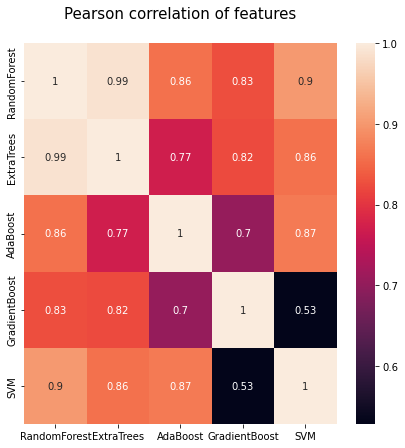

In [59]:
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(7,7))
plt.title('Pearson correlation of features', y=1.05, size=15)
fig = sns.heatmap(acc_pred_train.astype(float).corr(), annot=True)
fig.figure.savefig("output.png",dpi=400)

In [60]:
x_train = np.column_stack((etc_train_pred, rfc_train_pred, ada_train_pred, gbc_train_pred, svc_train_pred))

In [61]:
def trainStackModel(x_train, y_train, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed,shuffle=True)
    gbm = xgb.XGBClassifier(
     eval_metric='mlogloss',
     use_label_encoder =False,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    y_train_pred = cross_val_predict(gbm, x_train, y_train, cv=cv)
    
    return scores

In [62]:
stackModel_scores = trainStackModel(x_train, y2_train, 5, 0)

In [63]:
acc_pred_train['StackingModel'] = stackModel_scores
acc_pred_train

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,SVM,StackingModel
0,0.786111,0.786111,0.780556,0.805556,0.783333,0.786111
1,0.794444,0.797222,0.763889,0.791667,0.791667,0.805556
2,0.811111,0.808333,0.816667,0.822222,0.808333,0.811111
3,0.772222,0.775000,0.747222,0.741667,0.783333,0.777778
4,0.796657,0.793872,0.807799,0.779944,0.802228,0.796657
